<a href="https://colab.research.google.com/github/prabal5ghosh/Deep-Learning-summer-school-2025-university-of-cote-d-Azur/blob/main/Lab_DLS_ViT_CLIP_SUJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img width=60% src="http://www.i3s.unice.fr/~lingrand/efeliaUnica.png"><br/><br/>
<font size=+3><b>Towards Visual Data - ViT and CLIP</b></font><br/><br/>
<font size=+1>Rémy Sun, Diane Lingrand and Frédéric Precioso<br/><br/>
    2025 - June/July</font><br/>
    </center>
    

This lab aims to familiarize you with the use of visual data in transformers and in combination with textual data.
* The first part of this lab will retrace the work you have done on textual
encoder only transformers last week with an image dataset this time.
* The second part will show you how the Vision Language pretraining framework CLIP functions and how pre-trained CLIP models can by used to relate textual and visual data.


# Setup


Below, we import some standard libraries.

In [1]:
# Standard libraries
import math
import os
import urllib.request
from functools import partial
from urllib.error import HTTPError
from tqdm.notebook import tqdm
import random

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision

%matplotlib inline

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "data/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/"

# Set seed to ensure that all operations are deterministic for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


In [2]:
# making the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cuda')

You may need to ensure you are running on a GPU to ensure you can train the vision transformer model used in this first part

In [3]:
torch.manual_seed(42)

DOWNLOAD_PATH = 'data/mnist'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)

test_set = torchvision.datasets.MNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)


100%|██████████| 9.91M/9.91M [00:00<00:00, 14.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 433kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.04MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.88MB/s]


You will notice that the classical MNIST split does not include a validation set.

**Question:** Implement a validation set like in previous labs.

In [7]:
len(train_set)

60000

In [8]:
len(test_set)

10000

In [6]:
# You code here!
train_portion = int(len(train_set) * 0.95)  # 95% for training
val_portion = len(train_set) - train_portion # remaining for validation

train_data, val_data = torch.utils.data.random_split(train_set, [train_portion, val_portion])

In [9]:
len(train_data)

57000

In [10]:
len(val_data)

3000

In [11]:
train_set = train_data
val_set = val_data

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE_TEST, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)

We are going to work on the classical MNIST dataset in this first part that you have already classified during the 'Introduction to pytorch and MLP' lab.

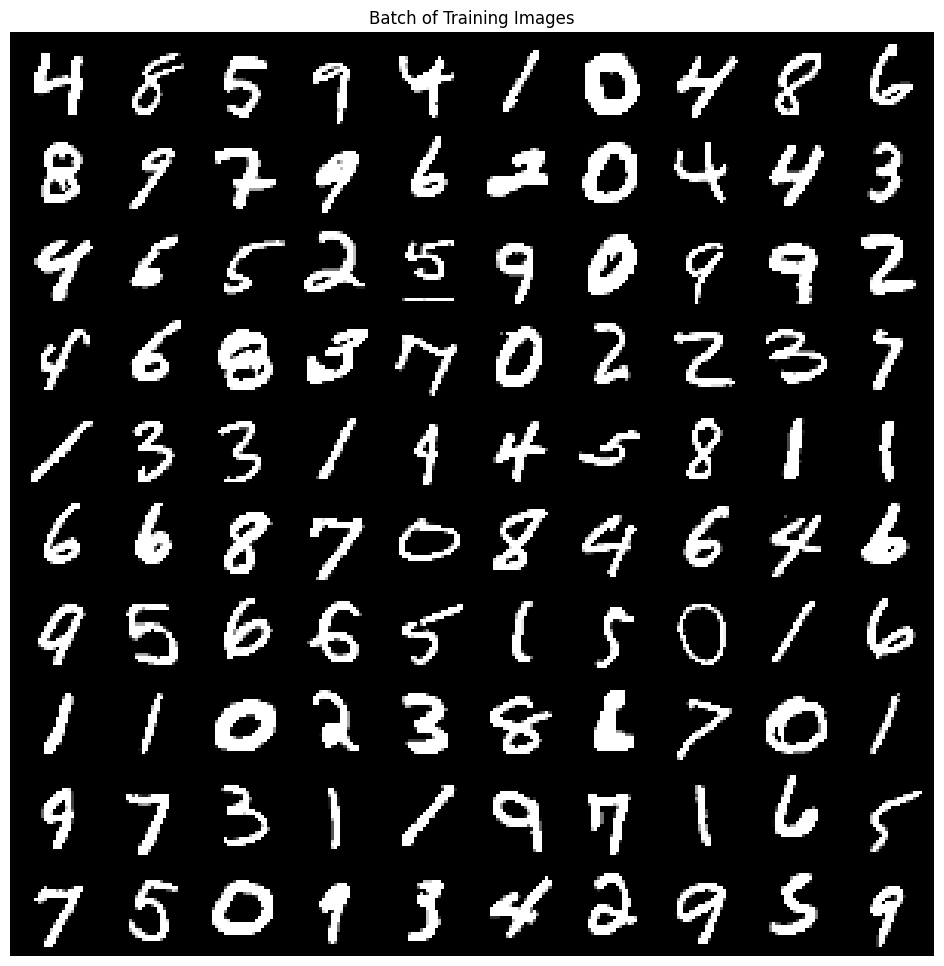

In [13]:
# Function to show a batch of images
def show_batch(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch
    grid = torchvision.utils.make_grid(images, nrow=10)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title("Batch of Training Images")
    plt.axis('off')
    plt.show()

# Print images for validation
show_batch(train_loader)

# Preparing the data

In [14]:
batch = next(iter(train_loader))

Let's have a look to a single image:

Text(0.5, 1.0, 'digit: 8')

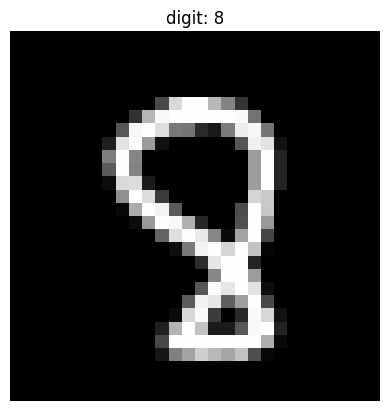

In [18]:
images, labels = batch
image = images[0]
label = labels[0]
plt.imshow(image.squeeze(), cmap='grey')
plt.axis('off')
plt.title('digit: '+ str(label.item()))

That could also be done using a single color channel and transposition:

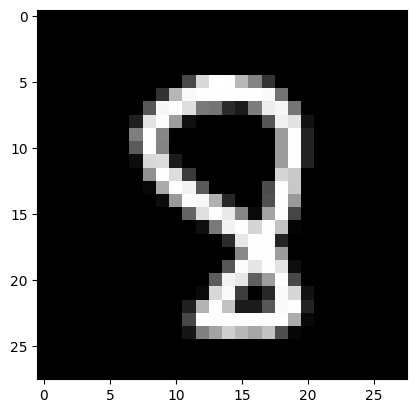

In [19]:
image = batch[0][0]
plt.imshow(image.numpy().transpose(1,2,0), cmap='grey')

In [20]:
image.shape

torch.Size([1, 28, 28])

## Tokenization

The first step to prepare data for a transformer is to divide the input into small sections that can then be transformed into transformer tokens. We will start by working on a single image to understand what we are doing.

**Question:** Transform one image into a collection of small image elements: 4x4 patches. You can use the .reshape method to break down the image into smaller patches, and you can reorder tensor dimensions with .swapaxes or .transpose!

In [77]:
# hint1: the first step is to reshape axis 1 and 2 as 28 = 7*4


patch_size = 4
# Reshape the image to divide it into 4x4 patches
patches = image.reshape(1, 28 // patch_size, patch_size, 28 // patch_size, patch_size)
print("patch shape: ", patches.shape)



patch shape:  torch.Size([1, 7, 4, 7, 4])


In [78]:
# hint2: then swap horizontal and vertical dimensions

# Swap dimensions to group the patch dimensions together
patches = patches.swapaxes(2, 3)
# Reshape to combine the patch grid dimensions and flatten the patch pixels
print()
print("patch shape: ", patches.shape)





patch shape:  torch.Size([1, 7, 7, 4, 4])


In [81]:
# hint3: reshape again in order to get (number of patches, 1, 4, 4)

patches = patches.reshape(1, -1, patch_size, patch_size)
# Remove the first dimension (batch size of 1 for a single image)
# patches = patches.squeeze(0)
print("")
print("patch shape: ", patches.shape)



patch shape:  torch.Size([1, 49, 4, 4])


In [82]:
28*28/16

49.0

In [83]:
patches.squeeze().shape

torch.Size([49, 4, 4])

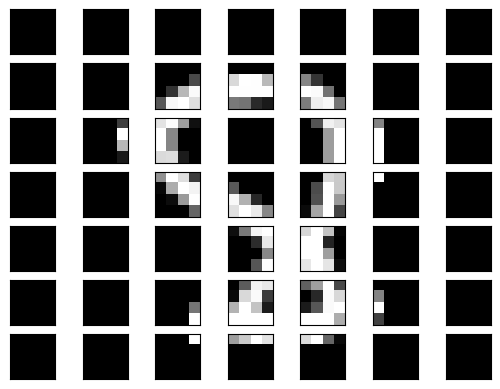

In [84]:
# hint4: a way to display to patches (helpful for debugging)
imgs = patches.squeeze()
fig, axs = plt.subplots(7,7)
nimg = 0
for i in range(7):
    for j in range(7):
        img = imgs[nimg]
        nimg +=1
        axs[i,j].imshow(img, cmap='grey')
        axs[i,j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



In [50]:
# Your code here!



You can visualize whether you properly separated the image into patches with the following bit of code. The expected dimension of the patchified image is (number of patches, patch_width, patch_height)

torch.Size([1, 49, 4, 4])


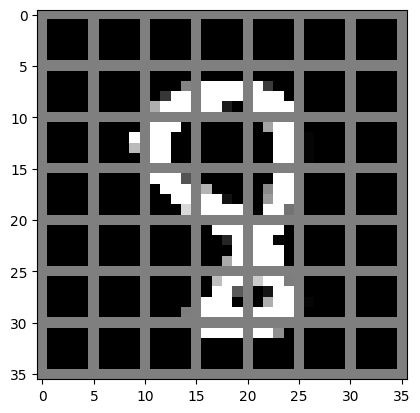

In [86]:
print(patches.shape)
patches = patches.swapaxes(0, 1)

grid = torchvision.utils.make_grid(patches, nrow=7,padding=1,pad_value=0.5)
plt.imshow(grid.numpy().transpose(1,2,0))
plt.show()

Now we can come back to dealing with a whole batch.

**Question:** Translate your previous code into a function that can take entire batches of images and transform them into batches of patches. The output shape is (batch size, number of pixels inside a patch, number of patches). You can use (-1) in order to compute automatically the batch size.

In [87]:
# Your code here!

def patchify(images_batch, patch_size):
    batch_size, channels, height, width = images_batch.shape
    # Reshape to divide the image into patches
    patches = images_batch.reshape(batch_size, channels, height // patch_size, patch_size, width // patch_size, patch_size)
    # Swap dimensions to group patch height and width together
    patches = patches.swapaxes(3, 4)
    # Reshape to combine the patch grid dimensions and flatten the patch pixels
    patches = patches.reshape(batch_size, channels, -1, patch_size * patch_size)
    # Swap dimensions to get shape (batch size, number of patches, channels * pixels per patch)
    patches = patches.swapaxes(1, 2)
    # Reshape to (batch size, number of patches, number of pixels inside a patch)
    patches = patches.reshape(batch_size, -1, channels * patch_size * patch_size)
    return patches

Shape of the original batch of images: torch.Size([1000, 1, 28, 28])
Shape of the patchified batch: torch.Size([1000, 49, 16])


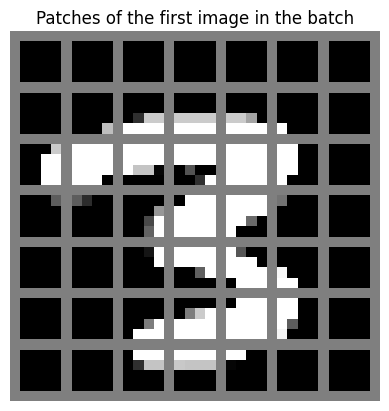

In [94]:
batch = next(iter(val_loader))


images, labels = batch
image = images[0]
label = labels[0]
# Patchify the images
patch_size = 4
patches_batch = patchify(images, patch_size)

print("Shape of the original batch of images:", images.shape)
print("Shape of the patchified batch:", patches_batch.shape)

patches_to_visualize = patches_batch[0].reshape(-1, 1, patch_size, patch_size)

grid = torchvision.utils.make_grid(patches_to_visualize, nrow=images.shape[2]//patch_size, padding=1, pad_value=0.5)
plt.imshow(grid.numpy().transpose(1,2,0), cmap='grey')
plt.title("Patches of the first image in the batch")
plt.axis('off')
plt.show()

### Embedding the patches

Now that we have broken down images into smaller patches, it is time to transform these patches into transformer input tokens. In natural language processing, we break down text into small units (e.g. words, phonemes, ...), assign an index to each small unit in our vocabulary and then use a nn.Embedding Layer to match each index (or small unit) to a learnable vector representation that can be processed by a transformer. Unfortunately, we cannot quite do that with image patches. However, we can compute a linear transformation of a single patch into an embedding using a linear layer.

**Question:** Write the code that will associate each patch to a learnable vector representation.

In [ ]:
# hint1
# each patch should be reshaped into a 1d-vector before applying a linear layer

In [ ]:
# Your code here!


**Question:** Now put in a new module class so we can have a neural network layer that takes image batches as inputs as outputs vectorized token batches.

In [ ]:
# Your code here!

class Tokenizer(nn.Module):
    def __init__(self, patch_size, embed_dim):
        super().__init__()


    def forward(self, x):

        return embeddings


### Bonus: Extracting tokens from images with 2D convolutions

Interestingly, it is possible to combine the two previous steps by using a 2D Convolution layer with the proper kernel and stride. This is how it is usually implemented in ViT.

**Question:** Write the code that takes a batch of images as input and outputs learnable vectors for the 49 4x4 patches in that image.

In [ ]:
# hint1:
# if the kernel size is 4x4 and the stride 4x4 then the convolution layer will compute
# a linear combinaison of every 4x4 patch in an image without overlapping.
# This linear combination is equivalent to what the previous linear layer was computing.

In [ ]:
# Your code here!

class TokenizerConv(nn.Module):
    def __init__(self, patch_size, embed_dim):
        super().__init__()



    def forward(self, x):

        return embeddings

### Building the model

Here we will build a simple model for image classification: we will rely on a Transformer Encoder combined with a final linear classification layer as you have seen last week. In this section, you will need to re-implement all the parts of the model as you have seen last week. Reminders on the different elements of the framework are provided below, please to try to re-implement all the modules without referring to last week's code!

### Standard attention scheme: Scaled Dot Product Attention

The core concept behind modern attention is the scaled dot product attention.
Our goal is to have an attention mechanism comparing each element in a sequence with any other (in an efficient way).
The dot product attention takes as input a set of queries
$Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$
and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length,
and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively.

In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

**Question:** Write out the scaled dot product attention function

In [ ]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]

    # Your code here!

    # Compute attn_logits

    # Apply mask if not None
    if mask is not None:

    # Pass through softmax

    # Weight values accordingly

    return output_values, attention

Note that our code above supports any additional dimensionality in front of the sequence length
so that we can also use it for batches.

You can check everything works properly by running the following test cell

In [ ]:
q = torch.tensor([[-0.8920, -1.5091],
        [ 0.3704,  1.4565],
        [ 0.9398,  0.7748]])
k = torch.tensor([[ 0.1919,  1.2638],
        [-1.2904, -0.7911],
        [-0.0209, -0.7185]])
v = torch.tensor([[ 0.5186, -1.3125],
        [ 0.1920,  0.5428],
        [-2.2188,  0.2590]])

output_values, attention = scaled_dot_product(q, k, v)

print("Output\n", output_values)
print("Attention\n", attention)

assert (output_values - torch.tensor([[-0.4846,  0.4063],
                                      [ 0.2174, -1.0264],
                                      [-0.0766, -0.8279]]) < 1e-4).all(), \
    f"Error in computing the attention"
assert (attention - torch.tensor([[0.0300, 0.6852, 0.2847],
                                  [0.8302, 0.0678, 0.1019],
                                  [0.7071, 0.0857, 0.2072]]) < 1e-4).all(), \
    f"Error in computing the attention"

Output
 tensor([[-0.4846,  0.4063],
        [ 0.2174, -1.0264],
        [-0.0766, -0.8279]])
Attention
 tensor([[0.0300, 0.6852, 0.2847],
        [0.8302, 0.0678, 0.1019],
        [0.7071, 0.0857, 0.2072]])


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence.
However, often there are multiple different aspects a sequence element wants to attend to,
and a single weighted average is not a good option for it.
This is why we extend the attention mechanisms to **multiple heads**,
i.e. multiple different query-key-value triplets on the same features.
Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys,
and sub-values, which we pass through the scaled dot product attention independently.
Afterward, we concatenate the heads and combine them with a final weight matrix.
Mathematically,

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters
$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$,
and $W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ ($D$ being the input dimensionality).
Expressed in a computational graph:

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network,
where we don't have an arbitrary query, key, and value vector as input?
Looking at the computation graph above, a simple but effective implementation is to set the current
feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$
($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$).
The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys, and values of the input.

**Question:** Implement a multi-head attention layer using the previously defined dot product attention function.

In [ ]:
class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim # dimension of concatenated heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Your code here!

        # Create linear layers for both qkv and output
        # TIP: Stack all weight matrices 1...h together for efficiency

    def forward(self, x, mask=None, return_attention=False):


        batch_dim, seq_length, input_dim = x.shape

        # Compute linear projection for qkv and separate heads
        # QKV: [Batch, Head, SeqLen, Dims]

        # Apply Dot Product Attention to qkv ()

        # Concatenate heads to [Batch, SeqLen, Embed Dim]

        # Output projection

        if return_attention:
            return o, attention
        else:
            return o


input_d = 3
seq_l = 4
embed_d = 4
n_heads = 2
b_size = 1

mh_att = MultiheadAttention(input_d, embed_d, n_heads)

x = torch.rand(b_size, seq_l, input_d)
x = torch.tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
print(f"Input x: {x}")

att_output = mh_att(x)
print(f"MhA Output {att_output}")
print(att_output.shape)
assert att_output.shape == torch.Size([1, 4, 4]), "Error in computing multi-head attention"

Input x: tensor([[[0.3360, 0.6676, 0.6393],
         [0.2083, 0.5484, 0.1204],
         [0.3533, 0.3038, 0.9383],
         [0.0499, 0.2048, 0.0107]]])
MhA Output tensor([[[-0.1891, -0.1790,  0.1462,  0.1397],
         [-0.1901, -0.1802,  0.1459,  0.1410],
         [-0.1944, -0.1821,  0.1432,  0.1449],
         [-0.1939, -0.1829,  0.1440,  0.1449]]], grad_fn=<ViewBackward0>)
torch.Size([1, 4, 4])


### Transformer Encoder

We can then use these attention layers to build the transformer encoder blocks and transformer encoder that you have see in previous labs:

<center width="100%"><img src="https://github.com/PyTorchLightning/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence.
Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above.
The output is added to the original input using a residual connection,
and we apply a consecutive Layer Normalization on the sum.
Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$
($x$ being $Q$, $K$ and $V$ input to the attention layer).

Additionally to the Multi-Head Attention, a small fully connected **Feed-Forward Network (FFN)** is added to the model,
which is applied to each position separately and identically.
Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP.
The full transformation including the residual connection can be expressed as:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    \text{output} & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

Also, we will assume now on a constant `input_dim = embed_dim` throughout the Transformer and therefore we will instantiate the attention as `MultiheadAttention(input_dim, input_dim, num_heads)`. The dimensionality of the first input will be addressed later.

**Question:** Build a transformer encoder block module below.

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Args:
            input_dim: Dimensionality of the input
            num_heads: Number of heads to use in the attention block
            dim_feedforward: Dimensionality of the hidden layer in the MLP
            dropout: Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Your code here!

        # Create Attention layer

        # Create Two-layer MLP with droput

        # Layers to apply in between the main layers (Layer Norm and Dropout)

    def forward(self, x, mask=None):
        # Compute Attention part

        # Compute MLP part

        return x



Based on this block, we can implement a module for the full **Transformer encoder**.
Additionally to a `forward` function that iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`.
The idea of this function is to return the attention probabilities for all Multi-Head Attention blocks in the encoder.
They helps us in understanding, and partially, explaining the model.
Attention scores may not necessarily reflect the true interpretation of the model (it is disputed in literature, check [Attention is not Explanation](https://arxiv.org/abs/1902.10186)
and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

**Question** Code the full transformer encoder block using the previous block.

In [ ]:
# Your code here!

class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()

    def forward(self, x, mask=None):

        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

### Transformer Encoder Classifier

Finally, we can implement a template for a classifier based on the Transformer encoder.

Additionally to the Transformer encoder we already coded, we add:
* a small network to transform input images in to sequences of tokens (coded at the beginning of this lab!)
* the positional encoding (you can implement a learned encoding or a 2D sine encoding by adapting what you have seen in previous labs)
* A classifier token to add to the input sequence before processing by the transformer encoder
* a classifier network that outputs a prediction from the classifier token features.

**Question:** Code the full image transformer classifier (this is a typical ViT architecture!)

In [ ]:
# Your code here!

class TransformerPredictor(nn.Module):
    def __init__(
        self,
        patch_size,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (28 // patch_size) ** 2
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout

        # Create positional encoding for sequences

        # Create transformer Encoder

        # Create output classifier per sequence element Model_dim -> num_classes

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        batch_size = x.size(0)


        if add_positional_encoding:

        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """Function for extracting the attention matrices of the whole Transformer for a single batch.

        Input arguments same as the forward pass.
        """
        batch_size = x.size(0)

        x = self.input_net(x)
        x = torch.cat([x,self.cls_token.repeat(batch_size, 1, 1)], dim=1)

        if add_positional_encoding:
            x += self.positional_embedding
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps



## Experiment: Sequence to Sequence

We can now train our model on the MNIST dataset and evaluate its performance!

**Question:** Complete the following functions to perform a single training step and evaluation step

In [ ]:
# Your code here!

def train_step(model, x, y, optim):
    model.train()

    x = x.to(device)
    y = y.to(device)

    # Perform prediction and calculate loss and accuracy

    # Backpropagate and update weights

    return loss, acc

def eval_step(model, x, y):
    with torch.no_grad():
        model.eval()

        x = x.to(device)
        y = y.to(device)


        # Perform prediction and calculate loss and accuracy

    return loss, acc


Finally, we can create a training function similar to the one we have seen in previous laboratories. We running for $N$ epochs printing the training and validation loss and saving our best model based on the validation.
Afterward, we test our models on the test set.

In [ ]:
def train_model(model, train_loader, val_loader, test_loader,
                optim, epochs=5):
    best_acc = 0.
    pbar = tqdm(range(epochs))
    for e in range(epochs):
        train_loss, train_acc = 0., 0.
        for x, y in train_loader:
            loss, acc = train_step(model, x, y, optim)
            train_loss += loss
            train_acc += acc

        val_loss, val_acc = 0., 0.
        for x, y in val_loader:
            loss, acc = eval_step(model, x, y)
            val_loss += loss
            val_acc += acc

        if val_acc/len(val_loader) > best_acc:
            torch.save(model.state_dict(), "best_model.pt")
            best_acc = val_acc/len(val_loader)

        pbar.update()
        pbar.set_description(f"Train Acc: {train_acc/len(train_loader)* 100:.2f} "
                            f"Train Loss: {train_loss/len(train_loader):.2f} "
                            f"Val Acc: {val_acc/len(val_loader)* 100 :.2f}  "
                            f"Val loss: {val_loss/len(val_loader):.2f} ")

    test_loss, test_acc = 0., 0.
    for x, y in test_loader:
        loss, acc = eval_step(model, x, y)
        test_loss += loss
        test_acc += acc

    print(f"Test accuracy: {test_acc/len(test_loader)*100 :.2f}")

    pbar.close()
    model.load_state_dict(torch.load("best_model.pt"))

    return model

Finally, we can train the model.
In this setup, we will use a single encoder block and a single head in the Multi-Head Attention.
This is chosen because of the simplicity of the task, and in this case, the attention can actually be interpreted
as an "explanation" of the predictions (compared to the other papers above dealing with deep Transformers).

In [ ]:
model = TransformerPredictor(
    patch_size = 4,
    input_dim=64,
    model_dim=64,
    num_heads=4,
    num_classes=10,
    num_layers=6,
    dropout=0.0,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001)

model = train_model(model, train_loader, val_loader, test_loader, optimizer)

As we would have expected, the Transformer can correctly solve the task. The performance is however fairly bad: even simple MLP architectures would be able to obtain 98+% accuracy nowadays. This is typically due to the low amount of data available and the lack of natural biases in the attention mechanism: transformers do not naturally look at local patterns when trained with limited training data.

### Bonus: Visualize the correlations learned by the ViT

To convince yourself of this, you can use the .get_attention_maps method built into our previous code to try to understand the correlations the ViT learns between different patches or "pixels"

**Question:** Investigate the correlations learned between patches

In [ ]:
# Your code here!

data_input, labels = next(iter(test_loader))
inp_data = data_input.to(device)


The object `attention_maps` is a list of length $N$ where $N$ is the number of layers.
Each element is a tensor of shape [Batch, Heads, SeqLen, SeqLen], which we can verify below.

In [ ]:
attention_maps[0].shape

torch.Size([1000, 4, 50, 50])

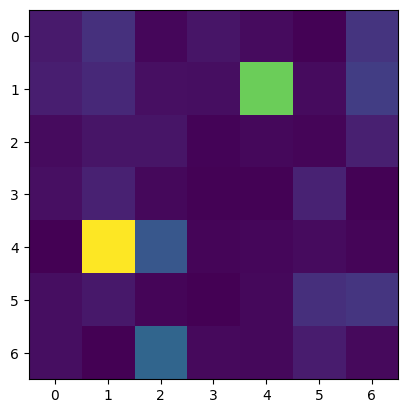

In [ ]:
plt.imshow(attention_maps[0][0][0][6][:-1].reshape(7,7).cpu())

# Towards multimodality: relating textual and visual data

Now that we have seen how we can deal with transform visual data to be processed by transformer models, we can look into how textual and visual data can be combined. A common way to work with visual and textual data is to at least start by learning representations that are aligned in a shared space.

The most common way to align textual and visual data lies in the CLIP framework discussed in class. The Contrastive Language-Image Pretraining (CLIP) framework learns both an image encoder and a text encoder. Given these models, it extracts feature representations for given images and texts. We then optimize the framework on a dataset of paired images and texts. For one optimization step, we optimize the models to ensure the embeddings of paired texts and images (positive pairs) are as closely aligned as possible while keeping non-paired texts and images (negative pairs) as different as possible. Note that we can typically assume image-text pairs in the dataset are positive pairs while any other combination of image-text (e.g. from two different dataset samples) are negative pairs.

We can typically quantify the alignment between two vectors u and v through dot product or cosine similarity: $$s(u,v) = \frac{u^T v}{\lVert u\rVert \lVert v\rVert}$$

If we follow this procedure with a very large amounts of 400 million, this yields very expressive and powerful image/text representations. Unfortunately, this is quite out of budget for this lab. We will therefore follow the [nanoCLIP](https://medium.com/@mahakal001/nanoclip-an-illustration-of-the-clip-framework-using-mnist-f281b161c9fa) exercise to train a much simpler CLIP model on the MNIST dataset: we pair images with a string of text representing their label (e.g. "One", "Two"). This is a very simplified view of text image alignment, but will help you understand the fundamental underlying parts of the framework.

## Building the Image and Text encoders

The first step for us is to define neural networks to encode our image and text input. Fortunately, we spent the earlier part of the day encoding a way to encode an image into an embedding space (let's say of size 10!).

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(
        self,
        patch_size,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (28 // patch_size) ** 2
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout
        self.input_net = TokenizerConv(4, self.model_dim)

        # Create positional encoding for sequences
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, self.model_dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.model_dim))

        # Create transformer Encoder
        self.transformer = TransformerEncoder(num_layers, input_dim=model_dim, dim_feedforward=model_dim*2, num_heads=num_heads, dropout=dropout)

        # Create output classifier per sequence element Model_dim -> num_classes
        self.output_net = nn.Linear(model_dim, num_classes)

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        batch_size = x.size(0)

        x = self.input_net(x)

        x = torch.cat([x,self.cls_token.repeat(batch_size, 1, 1)], dim=1)

        if add_positional_encoding:
            x += self.positional_embedding

        x = self.transformer(x, mask=mask)

        x = self.output_net(x[:,-1])

        return x

Now, what should we do for the text? Before thinking about an encoder, we need to tokenize our textual inputs into chunks for processing. Here, we are just going to consider each word as a sequence of letter for simplicity, with "."s to pad all the sequences to the same length for simplicity.

The code below provides all the tools to build the vocabulary and tokenizing functions.

**Question:** Write the encoding and decoding functions that allow us to switch between sequences of letters and sequences of vocabulary indexes.

In [ ]:
int_to_str = { 1 : "One..", 2 : "Two..", 3: "Three", 4: "Four.", 5: "Five.",
 6: "Six..", 7:"Seven", 8:"Eight", 9:"Nine.", 0: "Zero."}

# collect complete text in a big string
text = "".join([value for key, value in int_to_str.items()])

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
s_to_i = {ch: i for i, ch in enumerate(chars)}
i_to_s = {i: ch for i, ch in enumerate(chars)}

# Your code here!

def encode(s):

def decode(l):


Given properly sequences of vocabulary indexes, we then need to build an embedding layer to map the vocabulary indexes to learnable vectors.

**Question:** Complete the Tokenizer object below.

In [ ]:
# Your code here!

class TokenizerText(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()


    def forward(self, x):

        return embeddings

We can now get back to the issue of our textual encoder. Fortunately, we can take inspiration from what we did in previous labs and for images!

**Question:** Fill in the text encoder network below:

In [ ]:
# Your code here!

class TextEncoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        seq_len,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        dropout=0.0,
        input_dropout=0.0,
    ):
        """
        Args:
            input_dim: Hidden dimensionality of the input
            model_dim: Hidden dimensionality to use inside the Transformer
            num_classes: Number of classes to predict per sequence element
            num_heads: Number of heads to use in the Multi-Head Attention blocks
            num_layers: Number of encoder blocks to use.
            lr: Learning rate in the optimizer
            warmup: Number of warmup steps. Usually between 50 and 500
            max_iters: Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout: Dropout to apply inside the model
            input_dropout: Dropout to apply on the input features
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout = dropout
        self.input_dropout = input_dropout

        # Create a Generic Input Encoder Input dim -> Model dim with input dropout

        # Create positional encoding for sequences

        # Create transformer Encoder

        # Create output classifier per sequence element Model_dim -> num_classes

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Args:
            x: Input features of shape [Batch, SeqLen, input_dim]
            mask: Mask to apply on the attention outputs (optional)
            add_positional_encoding: If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        batch_size = x.size(0)


        if add_positional_encoding:

        return x

## Contrastive Learning framework

Now that we can extract feature embeddings from both image and text, it is time to learn how we can use contrastive learning to train our models. Given a batch of image/text pairs, we can extract the features and compute a similarity matrix

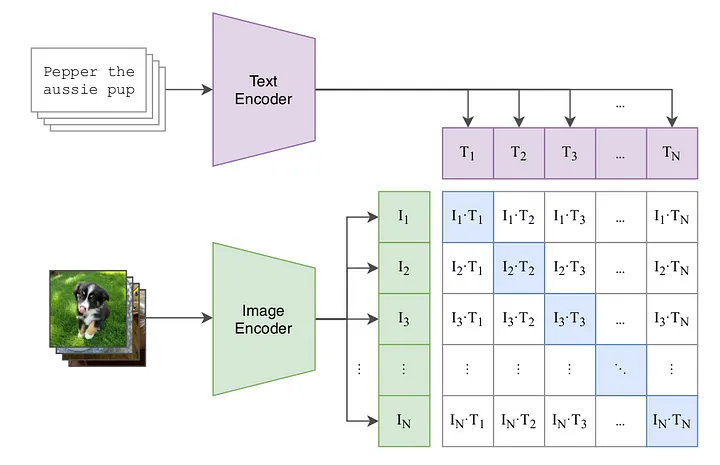

Once we have computed this matrix S, the ith row of this matrix gives us the similarity of the ith image in the batch with all the texts in the batch. For example, the first row gives us the similarity between the first image and the first text (positive pair), and then the similarities between this first image and each of the other texts in the batch (negative pairs).

To simplify things, we will train with all the negative pairs in the batch: we will optimize model to ensure the first image is as different as possible to all the texts excepts the first one. Naturally, this comes at a cost both computationally (we could sample less negative pairs) and semantically (there are going to be other images of the same number in the batch) but we will ignore this cost here.

In this case, the contrastive learning objective for images can be viewed as a simple prediction task using the similarity score in a row as pre-softmax logits and aiming to predict the index of the positive pair: for the ith image, we can optimize $$l^{CLIP}_{v, i} = CrossEntropy(S_{row i}, i)$$

Similarly, this would lead to optimizing over columns for text embeddings: $$l^{CLIP}_{t, i} = CrossEntropy(S_{col i}, i)$$

**Question** Complete the function below to perform one training iteration for clip.

In [ ]:
# Your code here!

def clip_step(model_v, model_t, img, text, optim):
    model_t.train()
    model_v.train()

    img = img.to(device)

    text = [int_to_str[int(i)] for i in text]
    text = [encode(s) for s in text]
    text = torch.tensor(text).to(device)

    # Perform prediction and calculate loss and accuracy

    # Compute the  similarity matrix

    # Compute the image and text losses

    # Backpropagate and update weights

    return loss


The overall training loop is very similar as we rely on the previously coded clip step.

In [ ]:
def train_clip(model_v, model_t, train_loader,
                optim, epochs=5):
    best_acc = 0.
    pbar = tqdm(range(epochs))
    for e in range(epochs):
        train_loss = 0.
        for x, y in train_loader:
            loss = clip_step(model_v, model_t, x, y, optim)
            train_loss += loss

        pbar.update()
        pbar.set_description(f"Train Loss: {train_loss/len(train_loader):.2f} ")

    pbar.close()

    return model_v, model_t

And now we can just put everyting together! Careful, we need to optimize both the text and visual encoder.

**Question** Complete the text below to ensure that both the text and visual encoders are updated by optim.

In [ ]:
model_v = ImageEncoder(
    patch_size = 4,
    input_dim=64,
    model_dim=64,
    num_heads=4,
    num_classes=10,
    num_layers=3,
    dropout=0.0,
).to(device)

model_t = TextEncoder(
    vocab_size = 20,
    seq_len = 5,
    input_dim=64,
    model_dim=64,
    num_heads=4,
    num_classes=10,
    num_layers=3,
    dropout=0.0,
).to(device)

# Your code here!

model_v, model_t = train_clip(model_v, model_t, train_loader, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

## Exploring the learned CLIP representations with retrieval

Now that we have obtained representations, we can check what kind of alignment we have obtained. With a larger CLIP model, we might be able to obtain complex descriptions of images or even retrieve images that fit a given description!

With our small nanoCLIP model however, the best we can do is obtain a pseudo classifier by checking the alignment of images with the different possible text labels (e.g. "one", ...)

**Question** Can you explore the first (or second, or third!) image in the batch below to check if it is properly aligned with the correct text label?

In [ ]:
data_input, labels = next(iter(test_loader))
inp_data = data_input.to(device)

In [ ]:
# Your code here!


# Perform prediction and calculate loss and accuracy


# Print out your results


tensor(3)
tensor([ 0.0778,  0.1814,  0.2170,  0.8714,  0.1016,  0.1808, -0.1652,  0.1189,
         0.3340,  0.2805], device='cuda:0', grad_fn=<DivBackward0>)
